In [8]:
import pandas as pd
import numpy as np
from time import time
import logging
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Loading the dataset

In [9]:
#faces = fetch_lfw_people('data', min_faces_per_person=70, resize=0.3)
#faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [10]:
n_samples, h, w = faces.images.shape
np.random.seed(42)

x = faces.data
n_features = x.shape[1]

y = faces.target
target_names = faces.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


# Splitting the Data into training and testing

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, 
                                                    random_state=42)

# Computing PCA:

In [12]:
n_components = 200
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

#Creating instances of PCA, initializing with n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver="randomized")
pca = pca.fit(X_train)
print("Done in %0.3fs" %(time()- t0))

Extracting the top 200 eigenfaces from 966 faces
Done in 0.129s


# Projecting the input data on the eigenfaces orthonormal basis:

In [13]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0=time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Done in %0.3fs" %(time()- t0))

Done in 0.020s


# Training a SVM Classification Model

In [14]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, Y_train)
print("Done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
Done in 30.473s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


# Evaluation of the Model:

In [15]:
y_pred = clf.predict(X_test_pca)

# Print classification report and accuracy score
print("Classification Report:")
print(classification_report(Y_test, y_pred, target_names=target_names))
print("Accuracy Score:", accuracy_score(Y_test, y_pred))

Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.62      0.59        13
     Colin Powell       0.74      0.88      0.80        60
  Donald Rumsfeld       0.77      0.74      0.75        27
    George W Bush       0.93      0.89      0.91       146
Gerhard Schroeder       0.83      0.80      0.82        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.88      0.83      0.86        36

         accuracy                           0.84       322
        macro avg       0.78      0.77      0.77       322
     weighted avg       0.84      0.84      0.84       322

Accuracy Score: 0.8385093167701864


# Plot Mean Face

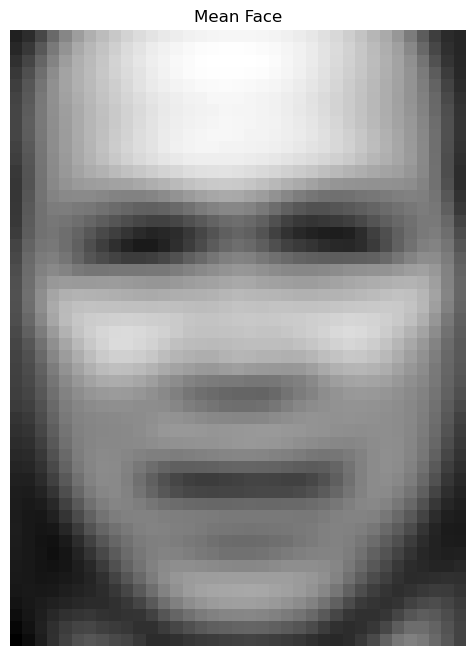

In [16]:
mean_face = pca.mean_.reshape((h, w))

# Plot the mean face
plt.figure(figsize=(8, 8))
plt.imshow(mean_face, cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

# Test Recognition

In [18]:
import cv2

# Provide the path to the input image
input_image_path = "D:/Bachelor/LFW dataset/Donald_Rumsfeld/Donald_Rumsfeld_0011.jpg"

# Load the input image
input_image = cv2.imread(input_image_path, 0)  # Load as grayscale image

# Resize the input image to match the dimensions used during training
resized_image = cv2.resize(input_image, (h, w))

# Flatten the resized image to match the shape used during training
flattened_image = resized_image.flatten()

# Perform dimensionality reduction on the flattened image using PCA
reduced_image = pca.transform([flattened_image])

# Predict the label for the reduced image using the trained SVM classifier
predicted_label = clf.predict(reduced_image)

# Get the predicted person's name
predicted_name = target_names[predicted_label[0]]

# Display the predicted name on the input image
cv2.putText(input_image, predicted_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Show the input image with the predicted label
cv2.imshow("Predicted Image", input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
